In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
sns.set_style("white")


In [124]:
def Vf(Tf3, Qf):
    # calculates vector coupling for the f quark
    # args-> Tf3: scalar, weak isosipin of f quark.
    #        Qf: scalar, charge of f quark
    # returns vf: scalar, vector copuling
    
    return Tf3 - 2*Qf*sin2w

def Af(Tf3):
    # calculates axial coupling for the f quark
    # args-> Tf3: scalar, weak isosipin of f quark.
    # returns af: scalar, vector copuling
    
    return Tf3

def Chi1(s_var):
    # calculates chi1 as a function of s
    # args -> s_var: array or scalar, for the s variable
    return k*s_var*(s_var-Mz**2)/( (s_var-Mz**2)**2 + Gammaz**2*Mz**2 )
    
def Chi2(s_var):
    # calculates chi1 as a function of s
    # args -> s_var: array or scalar, for the s variable
    return (k**2)*(s_var**2)/( (s_var-Mz**2)**2 + Gammaz**2*Mz**2)

def init_montecarlo(N_steps, s_constant=True):
    # initializes the values for the montecarlo integral
    
    # randomly generate the indices
    flavor_indices = np.random.randint(0,Nq, size=N_steps)

    # calculate the values for each step
    charge_sequence = np.asarray([quark_charges[x] for x in flavor_indices])
    isospin_sequence = np.asarray([quark_isospin[x] for x in flavor_indices])
    Aq_array = Af(isospin_sequence)
    Vq_array = Vf(isospin_sequence, charge_sequence)

    # draw random numbers for the integration
    if s_constant==True:
        s_var = Mz**2
        fs = 1.0
        
    costh = np.random.uniform(low=-1, high=1, size=(N_steps))
    phi = np.random.uniform(low=0, high=2*np.pi, size=(N_steps))

    return s_var, fs, costh, phi, Aq_array, Vq_array, charge_sequence


def diff_cross_section(s_var, costh, fs, Qq ,Aq, Vq):
    # evaluates the differential cross section at the given points
    # args-> s: array/scalar, random numbers for the s varialbe
    #        costh: array/scalar, random numbers following a cos distribution
    #        phi:   array/sacalar, random numbers for the angle phi
    # returns-> array: the differential cross section evaluated on the given points
    
    return (fs/(s_var*64.0*np.pi**2)) * ( (4*np.pi*alpha)**2*Nc*( (1+costh**2)*(Qe**2*Qq**2 \
                   + 2*Qe*Qq*Ve*Vq*Chi1(s_var) + (Ae**2+Ve**2)*(Aq**2 + Vq**2)*Chi2(s_var))\
                   + costh*( 4*Qe*Qq*Ae*Aq*Chi1(s_var) + 8*Ae*Ve*Aq*Vq*Chi2(s_var) ) ) )
                          

In [125]:
#INITIALIZE CONSTANTS

# qed coupling
alpha = 1.0/129.0
# Z boson mass
Mz = 91.2
# Z decay width
Gammaz = 2.5
# qcd colors
Nc = 3.0
# qcd light quark flavors
Nq = 5.0
# electric charge of electron
Qe = -1.0
# electric charge of light up type quarks
Qu = 2.0/3.0
# electric charge of down quarks
Qd = -1.0/3.0
# weinberg angle function
sin2w = 0.223
# prefactor for chi functions
k = 1/(4.0*sin2w*(1-sin2w))

# weak isospin for down type and electros
T3e = -1.0/2.0
# weak isospin for up type (light)
T3u = 1.0/2.0
# conversion factor to picobars
F_conv = 3.89379656 * 10**8

# electron values
Ae = Af(T3e)
Ve = Vf(T3e, Qe)

# each step of the montecarlo has to choose one of the flavors randomly
# order in the arrays is important, it is necesarry to keep 5 quarks to mantain the distribution of 
# events
quark_charges = np.asarray([Qu,Qu,Qd,Qd,Qd])
quark_isospin = np.asarray([T3u,T3u,T3e,T3e,T3e])



In [83]:
np.random.randint(0,5, size=20)


array([2, 0, 4, 4, 0, 4, 0, 4, 2, 0, 3, 2, 0, 3, 1, 3, 0, 3, 2, 0])

## Problem 1: Fixed s

In [105]:
benchmark_value = 42_250

In [110]:
# integration values
N_montecarlo = 1_000_000

# initialize the values
s, fs, costh, phi, Aq_array, Vq_array, charge_sequence = init_montecarlo(N_montecarlo)


# integration interval for cos(theta)
volume_interval = 2.0
# value of the integral for phi
phi_integral = 2*np.pi

# calculate the cross section at several points
sigma_eval = diff_cross_section(s, costh, fs, 
                   charge_sequence ,Aq_array, Vq_array)

# perform the ingral estimate
sigma_res = Nq*phi_integral*volume_interval*(np.mean(sigma_eval))*F_conv

# calculate the uncertainty
montecarlo_uncertainty = 2 * np.sqrt( (np.mean(sigma_eval**2) - np.mean(sigma_eval)**2) 
                                     /float(N_montecarlo))*F_conv*Nq*phi_integral*volume_interval

print('value = ', sigma_res, '+ - ', montecarlo_uncertainty, 'pb')
print('true = ', benchmark_value, 'pb')
print('error = ', np.abs(sigma_res-benchmark_value), 'pb')


value =  42219.518998234314 + -  25.4949275168934 pb
true =  42250 pb
error =  30.481001765685505 pb


In [113]:
# calculate the cross section for several max montecarlo points
N_list = np.linspace(10, 10**6,30).astype(int)
volume_interval = 2
phi_integral = 2*np.pi

sigma_list = []
uncertainty_list = []
error_list = []

for n in N_list:
    # initialize the values
    s, fs, costh, phi, Aq_array, Vq_array, charge_sequence = init_montecarlo(n)
    sigma_eval = diff_cross_section(s, costh, fs, 
                   charge_sequence ,Aq_array, Vq_array)
    
    sigma_res = Nq*phi_integral*volume_interval*(np.mean(sigma_eval))*F_conv
    
    # calculate the uncertainty
    montecarlo_uncertainty = 2 * np.sqrt( (np.mean(sigma_eval**2) - np.mean(sigma_eval)**2) 
                                     /float(n)) *F_conv*Nq*phi_integral*volume_interval 
    
    error = np.abs(sigma_res-benchmark_value)
    
    sigma_list.append(sigma_res)
    uncertainty_list.append(montecarlo_uncertainty)
    error_list.append(error)
    

Text(0, 0.5, '$\\sigma$')

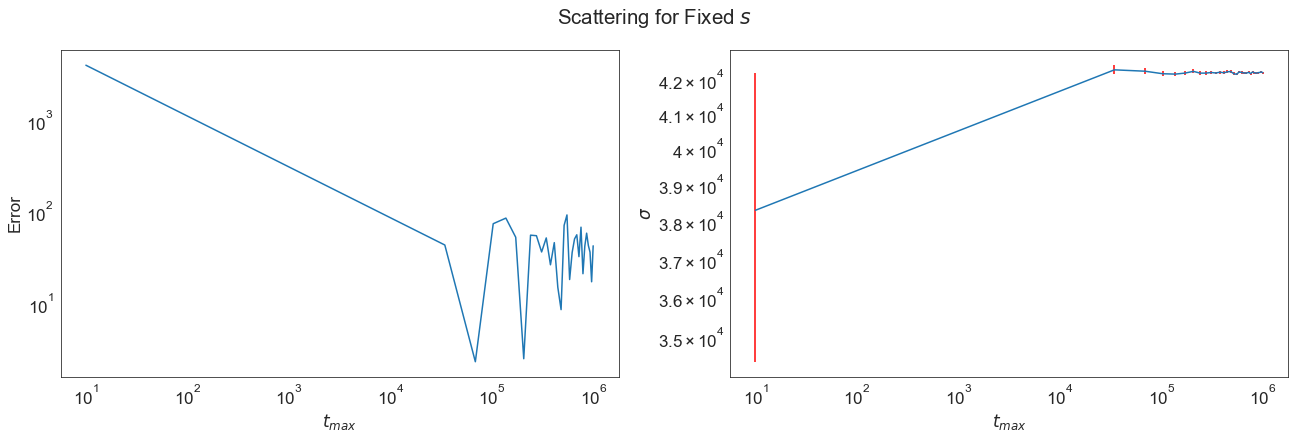

In [149]:
plt.figure(figsize=(22,6))
plt.tight_layout()
plt.suptitle('Scattering for Fixed $s$')

plt.subplot(1,2,1)
plt.loglog(N_list, error_list)
plt.xlabel('$t_{max}$')
plt.ylabel('Error')

plt.subplot(1,2,2)
plt.errorbar(N_list, sigma_list, yerr=uncertainty_list,ecolor='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$t_{max}$')
plt.ylabel('$\sigma$')
